In this tutorial, we will utilize a simulated processed loggerhead sea turtle (Caretta caretta) track to explore how this pelagic forager interacts with mesoscale oceanographic features. 

We will also use the Sea Surface Height (SSH) - derived mesoscale eddy product maintained by AVISO. Access to AVISO data products is free, but requires an account. If you do not already have an account, create one here: https://www.aviso.altimetry.fr/en/data/data-access/registration-form.html

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

First, let's load in our processed satellite-derived animal track and make sure it looks reasonable. The geographic domain information will be useful for matching with mesoscale oceanography later in the tutorial.

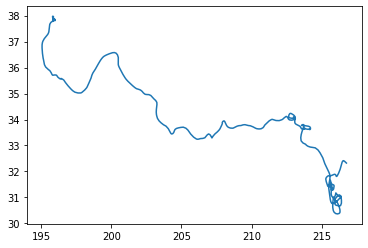

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

url = "https://raw.githubusercontent.com/oceanhackweek/ohw19-projects-Trackpy/7d62174c4188a0f3d4aaadf848ef91e36da63289/data/example_turtle_track.csv"
track_ex = pd.read_csv(url, parse_dates=['datetime'])
#lat_min = track_ex.lat.min()
#lat_max = track_ex.lat.max()
#lon_min = track_ex.lon.min()
#lon_max = track_ex.lon.max()
time_min_eddy = track_ex.datetime.min() 
time_max_eddy = track_ex.datetime.max() 

track_ex["lon"] = np.where(
    track_ex["lon"] < 180,
    track_ex["lon"] + 360,
    track_ex["lon"])

lat_min = track_ex["lat"].min() - 2.0
lat_max = track_ex["lat"].max() + 2.0
lon_min = track_ex["lon"].min() - 2.0
lon_max = track_ex["lon"].max() + 2.0

xy_bbox = dict(latitude=slice(lat_min,lat_max), longitude=slice(lon_min,lon_max))




plt.plot(track_ex.lon,track_ex.lat)

In [3]:
erddap_opendap_url =  'https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdBAssta5day'
ds = xr.open_dataset(erddap_opendap_url)
ds

<xarray.Dataset>
Dimensions:    (altitude: 1, latitude: 1501, longitude: 3601, time: 3880)
Coordinates:
  * time       (time) datetime64[ns] 2002-07-06T12:00:00 ... 2014-03-05T12:00:00
  * altitude   (altitude) float64 0.0
  * latitude   (latitude) float64 -75.0 -74.9 -74.8 -74.7 ... 74.8 74.9 75.0
  * longitude  (longitude) float64 0.0 0.1 0.2 0.3 ... 359.7 359.8 359.9 360.0
Data variables:
    sst        (time, altitude, latitude, longitude) float32 ...
Attributes:
    acknowledgement:               NOAA NESDIS COASTWATCH, NOAA SWFSC ERD
    cdm_data_type:                 Grid
    composite:                     true
    contributor_name:              Remote Sensing Systems Inc, JAXA, NASA, OS...
    contributor_role:              Source of level 2 data.
    Conventions:                   COARDS, CF-1.6, ACDD-1.3
    creator_email:                 erd.data@noaa.gov
    creator_name:                  NOAA NMFS SWFSC ERD
    creator_type:                  institution
    creator_url:   

In [4]:
from datetime import datetime, timedelta

time_min_sst = pd.to_datetime(track_ex['datetime'].min()) - timedelta(minutes=10080)
time_max_sst = pd.to_datetime(track_ex['datetime'].max()) + timedelta(minutes=10080)

subset = ds.sel(time=slice(time_min_sst, time_max_sst), **xy_bbox)


In [5]:
subset_sst = subset.sst
subset_sst.load();

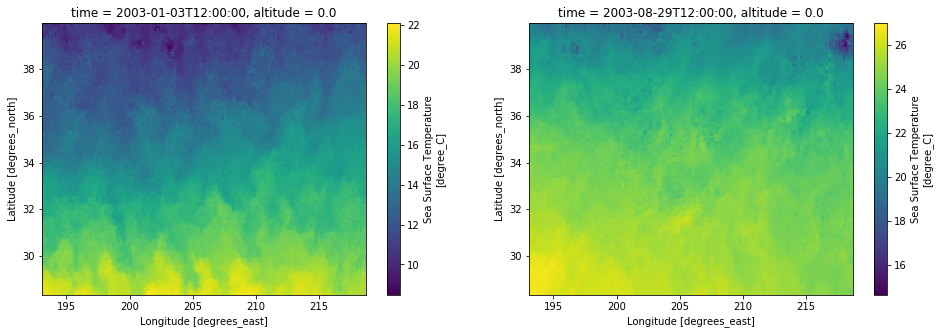

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5))
subset_sst.isel(time=0).plot(ax=ax1)
subset_sst.isel(time=-1).plot(ax=ax2);

In [7]:
sst_df_list = []
for index, row in track_ex.iterrows():
    row_time = pd.to_datetime(row["datetime"]) 
    x = row_time.strftime('%Y-%m-%d')
    row_lat_min = row["lat"] - 0.1
    row_lat_max = row["lat"] + 0.1
    row_lon_min = row["lon"] - 0.05
    row_lon_max = row["lon"] + 0.05
    row_bbox = subset_sst.sel(latitude=slice(row_lat_min,row_lat_max), longitude=slice(row_lon_min,row_lon_max))
    row_sst= row_bbox.sel(time=x)
    sst_xy_mean = row_sst.mean(dim=('latitude', 'longitude'))
    row_todf = sst_xy_mean.to_dataframe()
    #row_todf = row_sst.to_dataframe()
    sst_df_list.append(row_todf)
    #track_ex[]
    
sst_df = pd.concat(sst_df_list, ignore_index = True)


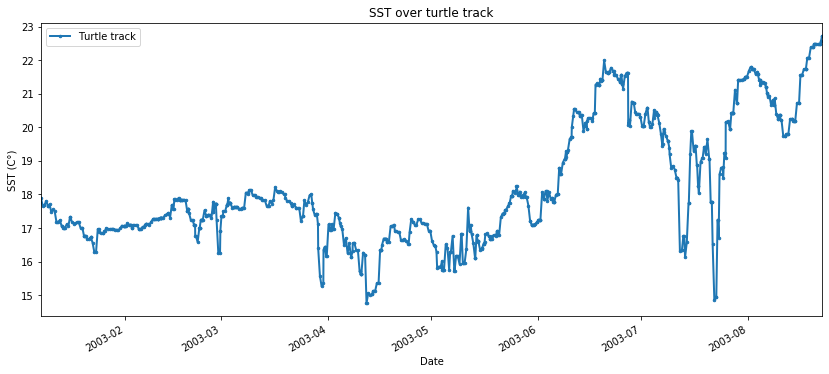

In [8]:
track_ex = pd.concat([track_ex, sst_df], axis=1)
ax = track_ex.plot(x ='datetime', y='sst', figsize=(14,6), lw=2, marker='.', markersize=5, title="SST over turtle track")
ax.set_xlabel("Date")
ax.set_ylabel("SST (C°)")
ax.legend(["Turtle track"])

In this step, you will be asked for your AVISO login credentials in order to interact with their mesoscale eddy track database. 

In [24]:
import ftplib
from ftplib import FTP
import getpass
import os.path
from os import path

if not path.exists('eddy_trajectory_2.0exp_19930101_20180118.nc'):
    ftp_add =  'ftp-access.aviso.altimetry.fr'

    username = input('username:')
    password = getpass.getpass()

    ftp = FTP(ftp_add)
    ftp.login(username,password)
    ftp.cwd('value-added/eddy-trajectory/delayed-time/')
    filename = 'eddy_trajectory_2.0exp_19930101_20180118.nc'
    f = open(filename, "wb")
    ftp.retrbinary("RETR " + filename, f.write, 8*1024)
    f.close()
    ftp.close() 


username: woestreich@stanford.edu
 ······


Next, we can subset the eddy database to match the geospatial domain of the animal track. Because the eddy database is stored with observation numbers as the only dimension (and with many replicate times and locations from different eddy tracks), slicing with xarray is challenging. Instead, we perform this relatively simple subset operation using the netCDF module and straightforward boolean operators.

In [170]:
import numpy as np
import netCDF4
from netCDF4 import Dataset
from datetime import date, timedelta 
import pandas as pd

eddys = Dataset('eddy_trajectory_2.0exp_19930101_20180118.nc')
t = np.array(eddys['time'])
lat = np.array(eddys['latitude'])
lon = np.array(eddys['longitude'])
cyclonic_type = np.array(eddys['cyclonic_type'])
track = np.array(eddys['track'])
radius = np.array(eddys['speed_radius'])

t = t.astype(np.int32)
dates = pd.to_datetime("1950-01-01 12:00:00")
eddy_time = dates + pd.TimedeltaIndex(t, unit='D')

lon = np.where(
    lon > 180,
    lon - 360,
    lon)

subset = (lat >= lat_min) & (lat <= lat_max) & (lon >= lon_min) & (lon <= lon_max) & (eddy_time >= time_min_eddy) & (eddy_time <= time_max_eddy)
lat = lat[subset]
lon = lon[subset]
eddy_time = eddy_time[subset]
cyclonic_type = cyclonic_type[subset]
track = track[subset]
radius = radius[subset]

eddy_df = pd.DataFrame({"lat":lat,
                        "lon":lon,
                        "datetime":eddy_time,
                        "track":track,
                        "radius":radius,
                        "cyclonic_type":cyclonic_type})
eddy_df.loc[eddy_df['cyclonic_type'] == 1,'color'] = 'red'
eddy_df.loc[eddy_df['cyclonic_type'] == -1,'color'] = 'blue'
eddy_df.head()

,lat,lon,datetime,track,radius,cyclonic_type,color
0,35.824799,-150.727997,2003-01-08 12:00:00,65309,63,1,red
1,35.816601,-150.710999,2003-01-09 12:00:00,65309,64,1,red
2,35.820499,-150.768005,2003-01-10 12:00:00,65309,102,1,red
3,35.814301,-150.789993,2003-01-11 12:00:00,65309,101,1,red
4,35.807201,-150.787003,2003-01-12 12:00:00,65309,100,1,red


Let's visualize some of these interactions with mesoscale oceanography!

In [185]:
import folium
from folium.plugins import TimestampedGeoJson

track_ex["lon"] = np.where(
    track_ex["lon"] > 180,
    track_ex["lon"] - 360,
    track_ex["lon"])

locations = track_ex[['lat', 'lon']]
locationlist = locations.values.tolist()
eddylocations = eddy_df[['lat', 'lon']]
eddylocationlist = eddylocations.values.tolist()

def create_geojson_features(df):
    print('> Creating GeoJSON features...')
    features = []
    for _, row in df.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point', 
                'coordinates':[row['lon'],row['lat']]
            },
            'properties': {
                'time': row['datetime'].date().__str__(),
                'style': {'color' : 'black','weight' : 1, 'opacity' : 0.75},
                'icon': 'circle',
                'iconstyle':{
                    'fillColor': 'green',
                    'fillOpacity': 0.5,
                    'stroke': 'true',
                    'radius': 4
                }
            }
        }
        features.append(feature)
    return features

def create_geojson_eddy_features(df):
    print('> Creating GeoJSON Eddy features...')
    features = []
    for _, row in df.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point', 
                'coordinates':[row['lon'],row['lat']]
            },
            'properties': {
                'time': row['datetime'].date().__str__(),
                'style': {'color' : 'black','weight' : 1, 'opacity' : 0.75},
                'icon': 'circle',
                'iconstyle':{
                    'fillColor': row['color'],
                    'fillOpacity': 0.5,
                    'stroke': 'true',
                    'radius': row['radius']/5
                }
            }
        }
        features.append(feature)
    return features

features = create_geojson_features(track_ex)
eddy_features = create_geojson_eddy_features(eddy_df[500:4500])
#print(eddy_features[0:10])
#features
m = folium.Map(location=[track_ex.lat.mean(), track_ex.lon.mean()], zoom_start=5, tiles=None, control_scale=True)
folium.raster_layers.TileLayer('OpenStreetMap').add_to(m)
folium.raster_layers.TileLayer('stamenterrain').add_to(m)
TimestampedGeoJson(
    [{'type': 'FeatureCollection',
    'features': features},
    {'type': 'FeatureCollection',
    'features': eddy_features}]
    , period='P1D'
    , add_last_point=True
    , auto_play=False
    , loop=False
    , max_speed=1
    , loop_button=True
    , date_options='YYYY/MM/DD'
    , time_slider_drag_update=True
    , duration='P1D'
).add_to(m)


feature_group = folium.FeatureGroup(name='Track Line', overlay=True, control=True, show=False)
folium.PolyLine(locationlist,weight=5,color = 'red').add_to(feature_group)
#for point in range(0, 1000):# len(eddylocationlist)):
#    folium.CircleMarker(eddylocationlist[point],
#                        radius=3,
#                        weight=2).add_to(m)
folium.plugins.Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True
).add_to(m)
m.add_child(feature_group) 
m.add_child(folium.map.LayerControl())

m

> Creating GeoJSON features...
> Creating GeoJSON Eddy features...
